In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sqlite3
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

con = sqlite3.connect("/content/gdrive/My Drive/Colab Notebooks/wildfires.sqlite")

In [ ]:
CATEGORICAL = ["NWCG_REPORTING_AGENCY", "FIRE_SIZE_CLASS", "STATE"]
NUMERICAL = ["FIRE_YEAR", "DISCOVERY_DOY", "DISCOVERY_DATE", "STAT_CAUSE_CODE", "CONT_DOY", "CONT_DATE", "FIRE_SIZE", "LATITUDE", "LONGITUDE", "OWNER_CODE"]
fires_table = pd.read_sql_query("SELECT * from Fires", con)
wildfires = fires_table[NUMERICAL + CATEGORICAL]

In [ ]:
wildfires.size

24446045

In [ ]:
large_wildfires = wildfires[~(wildfires["FIRE_SIZE_CLASS"].isin(["A", "B", "C"]))]
large_wildfires.size

703209

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
d = defaultdict(LabelEncoder)

# Encoding the variable
large_wildfires = large_wildfires.apply(lambda x: d[x.name].fit_transform(x))

# # Inverse the encoded
# fit.apply(lambda x: d[x.name].inverse_transform(x))

# # Using the dictionary to label future data
# df.apply(lambda x: d[x.name].transform(x))

To start with our supervised learning approaches, we drop attributes related to the fire size and split the data into train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

x = large_wildfires.drop(["FIRE_SIZE_CLASS", "FIRE_SIZE"], 1)
X_train, X_test, y_train, y_test = train_test_split(x, large_wildfires["FIRE_SIZE_CLASS"], test_size=0.3, random_state=15)

In [ ]:
X_train.size, y_train.size

(416515, 37865)

In [ ]:
X_train.head()

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_DATE,STAT_CAUSE_CODE,CONT_DOY,CONT_DATE,LATITUDE,LONGITUDE,OWNER_CODE,NWCG_REPORTING_AGENCY,STATE
982695,4,63,1283,8,13902,19472,2010,43015,13,9,8
558669,8,0,2464,4,17713,8148,20777,19575,13,9,31
265261,14,221,4571,0,221,4059,36688,22870,1,0,40
997072,8,202,2659,0,10328,21575,4249,41446,13,9,8
1523251,17,290,5668,1,290,5070,8983,23016,12,9,42


As a baseline classifier, we simply assign the most common fire size class to each fire. Our models must improve upon this number.

In [ ]:
large_wildfires["FIRE_SIZE_CLASS"].value_counts().max() / large_wildfires["FIRE_SIZE_CLASS"].size

0.5255208622187714

We start using a Gaussian Naive Bayes classifier. However, we expect poor performance because the features should be strongly correlated.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [ ]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
gnb.score(X_test, y_test)

0.44971653931476463

In [ ]:
print(classification_report(y_test, y_pred, target_names=["D", "E", "F", "G"]))

              precision    recall  f1-score   support

           D       0.61      0.75      0.67      8423
           E       0.28      0.01      0.03      4354
           F       0.19      0.06      0.09      2335
           G       0.16      0.70      0.26      1116

    accuracy                           0.45     16228
   macro avg       0.31      0.38      0.26     16228
weighted avg       0.43      0.45      0.39     16228



This simple approach did not achieve the desired accuracy, so we next try a decision tree. We use the Gini impurity to measure the quality of a split instead of entropy because it does not require computing the log, which is computationally expensive.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.4526127680552132

In [ ]:
clf.tree_.max_depth

46

In [ ]:
print(classification_report(y_test, y_pred, target_names=["D", "E", "F", "G"]))

              precision    recall  f1-score   support

           D       0.62      0.60      0.61      8423
           E       0.30      0.31      0.31      4354
           F       0.22      0.22      0.22      2335
           G       0.29      0.29      0.29      1116

    accuracy                           0.45     16228
   macro avg       0.36      0.36      0.36     16228
weighted avg       0.45      0.45      0.45     16228



Let's see if we can improve on this by varying the max_depth parameter.

In [ ]:
grid = {"max_depth": [20, 30, 40, 50, 60, 70, 80, 90]}
clf = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid)
y_pred = clf.fit(X_train, y_train).predict(X_test)
clf.score(X_test, y_test)

0.46999014049790483

In [ ]:
clf.best_params_

{'max_depth': 20}

In [ ]:
print(classification_report(y_test, y_pred, target_names=["D", "E", "F", "G"]))

              precision    recall  f1-score   support

           D       0.61      0.67      0.64      8423
           E       0.31      0.29      0.30      4354
           F       0.22      0.19      0.21      2335
           G       0.30      0.26      0.28      1116

    accuracy                           0.47     16228
   macro avg       0.36      0.35      0.36     16228
weighted avg       0.45      0.47      0.46     16228



We find that the accuracy increases by a slight amount but not to the level that we need. Let's try using a random forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.5195341385260044

Let's try some hyperparameter tuning.

In [ ]:
# n_estimators = [100, 200, 300]
# max_depth = [20, 30, 40, 50]
n_estimators = [200]
max_depth = [20]
grid = {"n_estimators": n_estimators, "max_depth": max_depth}

In [ ]:
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.5330909539068277

In [ ]:
clf.best_params_

{'max_depth': 20, 'n_estimators': 200}

Finally, we use the XGBoost (extreme gradient boosting) algorithm.

In [ ]:
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
clf = XGBClassifier(gamma=0.5, max_depth=5, subsample=0.8, min_child_weight=5)
y_pred = clf.fit(X_train, y_train).predict(X_test)
clf.score(X_test, y_test)

0.5400542272615233

In [ ]:
print(classification_report(y_test, y_pred, target_names=["D", "E", "F", "G"]))

              precision    recall  f1-score   support

           D       0.56      0.96      0.71      8423
           E       0.33      0.06      0.10      4354
           F       0.30      0.07      0.12      2335
           G       0.47      0.27      0.34      1116

    accuracy                           0.54     16228
   macro avg       0.42      0.34      0.32     16228
weighted avg       0.46      0.54      0.43     16228



In [ ]:
from sklearn.metrics import plot_confusion_matrix

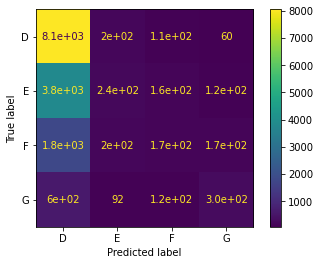

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=["D", "E", "F", "G"])

In [ ]:
from yellowbrick.classifier import ClassificationReport

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


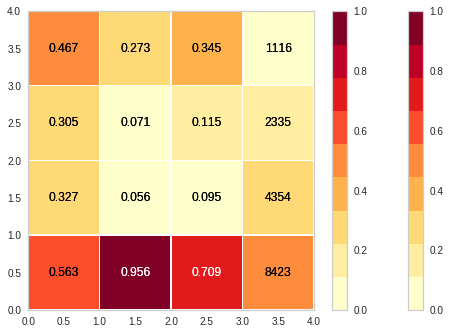

In [ ]:
clf = XGBClassifier(gamma=0.5, max_depth=5, subsample=0.8, min_child_weight=5)
visualizer = ClassificationReport(clf, classes=["D", "E", "F", "G"], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.draw()

In [ ]:
from sklearn.svm import SVC

In [ ]:
sample = large_wildfires.sample(frac=0.01)
x = sample.drop(["FIRE_SIZE_CLASS", "FIRE_SIZE"], 1)
X_train, X_test, y_train, y_test = train_test_split(x, sample["FIRE_SIZE_CLASS"], test_size=0.3, random_state=15)

In [ ]:
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.49079754601226994